# CSE327 Homework 4
**Due date: 23:59 on Nov. 20, 2018 (Thuesday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 100 points. There is no bonus question for this homework. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
You will be using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [8]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time
from datetime import datetime,timedelta

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import SGDClassifier

In [41]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
#     # norm data to zero-centered
#     mean_img = np.mean(np.array(data), 0)
#     data = data - mean_img
#     data = [data[i] for i in xrange(data.shape[0])]
    
    # augment data
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            #print("Before:",type(minibatch_d))
            #print("Before dim:", len(minibatch_d))
            #minibatch_store = minibatch_d
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            #print("After:",type(minibatch_d))
            #print("After shape:", minibatch_d.shape)
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    #print(minibatch_store[0].shape)
    #minibatch_store = np.reshape(minibatch_store,(50,1,64,64))
    #print(minibatch_store.shape)
    return zip(batch_data, batch_labels)

{0: 'Street', 1: 'Highway', 2: 'Coast', 3: 'Office', 4: 'InsideCity', 5: 'LivingRoom', 6: 'Mountain', 7: 'OpenCountry', 8: 'Forest', 9: 'Bedroom', 10: 'Industrial', 11: 'TallBuilding', 12: 'Suburb', 13: 'Kitchen', 14: 'Store'}


In [42]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

3000
50
(64, 64)
(50, 1, 64, 64)
Finish loading 60 minibatches(=50) of training samples.
1500
50
(64, 64)
(50, 1, 64, 64)
Finish loading 30 minibatches(=50) of testing samples.


Store


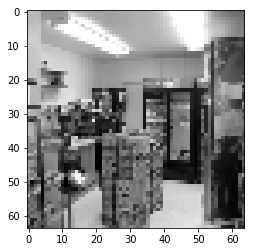

In [4]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

In [7]:
for i,(image,label) in enumerate(trainloader_small):
    print(image.shape)

torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 64, 64])
torch.Size([50, 1, 6

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [5]:
# ==========================================
#       Define Network Architecture
# ==========================================
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            #nn.Sigmoid()
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            #nn.Sigmoid
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout2d()
        self.fc1 = nn.Linear(16 * 16 * 64, 1000)
        self.fc1_bn = nn.BatchNorm1d(16*16*64)
        self.fc2 = nn.Linear(1000, 15)
    
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1_bn(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [8]:
# ==========================================
#         Optimize/Train Network
# ==========================================
#Define some parameters of the network
num_epochs = 10
num_classes = 15
batch_size = 50
learning_rate= 0.001

model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training the network
total_step = len(trainloader_small)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_small):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 50 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Loss: 2.3479, Accuracy: 26.00%
Epoch [2/10], Loss: 1.9699, Accuracy: 46.00%
Epoch [3/10], Loss: 1.7177, Accuracy: 50.00%
Epoch [4/10], Loss: 1.4914, Accuracy: 56.00%
Epoch [5/10], Loss: 1.3162, Accuracy: 56.00%
Epoch [6/10], Loss: 1.0999, Accuracy: 64.00%
Epoch [7/10], Loss: 0.9671, Accuracy: 66.00%
Epoch [8/10], Loss: 0.8341, Accuracy: 74.00%
Epoch [9/10], Loss: 0.7505, Accuracy: 70.00%
Epoch [10/10], Loss: 0.6701, Accuracy: 80.00%


In [9]:
# ==========================================
#            Evaluating Network
# ==========================================
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader_small:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 1500 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 1500 test images: 61.46666666666667 %


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [10]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

1500
50
Finish loading 30 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


In [14]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
##Implementation of Strategy B
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

#Defining the parameters
num_epochs = 20
num_classes = 15
batch_size = 50
learning_rate = 0.001

# convert all the layers to list and remove the last one
nu_ftrs = alexnet.classifier[6].in_features
#print(nu_ftrs)

features = list(alexnet.classifier.children())[:-1]
#print(features)
#Updated AlexNet
features.extend([nn.Linear(nu_ftrs,num_classes)])
alexnet.classifier = nn.Sequential(*features)
print(alexnet.classifier)

#Defining the Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, momentum=0.9)

Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=4096, out_features=15, bias=True)
)


In [19]:
def getTime(time):
    sec = timedelta(seconds = time)
    d = datetime(1,1,1) + sec
    print("Time required for the process:")
    print("Days:Hours:Minutes:Seconds")
    print("%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second))


total_step = len(trainloader_large)
loss_list = []
acc_list =[]

#Training the network
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_large):
        outputs = alexnet(images)
        loss = criterion(outputs,labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        if (i+1) % 30 == 0:
             print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, loss.item(),
                          (correct / total) * 100))
end_time = time.time()
total_time = end_time - start_time
getTime(total_time)

Epoch [1/20], Loss: 0.0580, Accuracy: 98.00%
Epoch [2/20], Loss: 0.0249, Accuracy: 100.00%
Epoch [3/20], Loss: 0.0136, Accuracy: 100.00%
Epoch [4/20], Loss: 0.0078, Accuracy: 100.00%
Epoch [5/20], Loss: 0.0309, Accuracy: 98.00%
Epoch [6/20], Loss: 0.0137, Accuracy: 100.00%
Epoch [7/20], Loss: 0.0202, Accuracy: 100.00%
Epoch [8/20], Loss: 0.0033, Accuracy: 100.00%
Epoch [9/20], Loss: 0.0196, Accuracy: 100.00%
Epoch [10/20], Loss: 0.0079, Accuracy: 100.00%
Epoch [11/20], Loss: 0.0058, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0399, Accuracy: 98.00%
Epoch [13/20], Loss: 0.0216, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0038, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0119, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0033, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0259, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0037, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0013, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0017, Accuracy: 100.00%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:35:53


In [20]:
start = time.time()
#Testing the network on the test dataset.
alexnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader_large:
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test accuracy over 1500 images: {}%'.format((correct/total)*100))
end = time.time()
total = end-start
getTime(total)

Test accuracy over 1500 images: 88.06666666666668%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:0:46


In [21]:
# ==========================================
#   Feature Extraction from the Network
# ==========================================
##Implementation of Strategy A

def removeLayer(alex_net):    
    new_classifier = nn.Sequential(*list(alex_net.classifier.children())[:-1])
    alex_net.classifier = new_classifier
    return alex_net

alex_net = models.alexnet(pretrained=True)
#print(alex_net)

alex_net = removeLayer(alex_net)
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [24]:
num_epochs = 10
num_classes = 15
batch_size = 50
learning_rate = 0.001

#Defining the Classifier used for training
model = SGDClassifier(loss="hinge", penalty="l2")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)

total_step = len(trainloader_large)
loss_list = []
acc_list =[]
output_list = []
#Training the network
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_large):
        #print(i)
        outputs = alex_net(images)
        #print(outputs.shape)
        model.partial_fit(outputs.data.numpy(),labels.data.numpy(), classes=range(num_classes))
print("Training completed!")
end_time = time.time()
total_time = end_time-start_time
getTime(total_time)

Training completed!
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:7:44


In [25]:
##Testing the trained data-set

#Function to test the testing data set on the trained SGD classifier
def test(testloader):
    scores_list = []
    for images, labels in testloader:
        test_outputs = alex_net(images)
        score_pred = model.score(test_outputs.data.numpy(), labels.data.numpy())
        #print(score_pred)
        scores_list.append(score_pred)
    return scores_list

#Function to get the percent value
def getPercent(ip_list):
    avg = sum(ip_list)/len(ip_list)
    percent = avg*100
    return(percent)

start_time = time.time()
scores_list = test(testloader_large)
percent = getPercent(scores_list)
end_time = time.time()
total_time = end_time - start_time
print("The Test accuracy over 1500 images in the test dataset is {}%".format(percent))
getTime(total_time)

The Test accuracy over 1500 images in the test dataset is 79.06666666666669%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:0:48


## ASSIGNMENT REPORT
**Problem 1: Training a Network from Scratch**:<br>
**Part 1:**<br>
I have implmented a Convolutional Neural Network from scratch to solve the first problem. The description of network which I have implemented is as follows:<br>
- Convolutional Layer 1: Convolutional Layer with kernel size $5\times5$, number of channels is 32 followed by a ReLU activation and a max pooling down sampling of $2\times2$ with stride of 2
- Convolutional Layer 2: Convolutional Layer with kernel size $5\times5$, number of channels is 64 followed by a ReLU activation and a max pooling down sampling of $2\times2$ with stride of 2<br>

After the above convolutional part of the network is over, the size of the image which is $64\times64$ reduces to $16\times16$. This part is then flattened and then fed to two linear layers and a preceding dropout layer:<br>
- Dropout Layer
- Linear Layer 1: Consists of the flatenned input from the convolutional neural network of size $16\times16\times64$ 
- BatchNorm Layer: Applying batch normalisation 
- Linear Layer 2: Consists of fully connected 1000 nodes
- Linear Layer 3: Consists of 15 nodes equalling the number of classes in our dataset<br>

The data augmentation and data normalization has already been performed in the starter code. The data is fed directly into the convolutional neural network.<br>
The parameters which have been changed and experimented with are documented below along with the parameters changed and required for part 1:<br>
The downsizing and the image based on the kernel size, padding and input image size has been calculated using the formula:<br>
$$W_{out} = \frac{W_{in} - F + 2P}{S} + 1$$

where $W_{out}$ is the width of the output image, similarly $W_{in}$ is the width of the input image. $F$ is the filter size, $P$ is the padding and $S$ si the stride.

**Part 2:**<br>
The different techniques which have been mentioned in the report have been tried out with the following results which have been documented below.<br>

| Optimizer | Activation 1 | Activation 2 | Dropout | BatchNorm | Accuracy |
| :-------: | :----------: | :----------: | :-----: | :-------: | :------: |
|   Adam    |     ReLU     |     ReLU     |   Yes   |    Yes    | 51.322%  |
|   Adam    |     ReLU     |     ReLU     |   No    |    No     | 34.222%  |
|    SGD    |     ReLU     |     ReLU     |   Yes   |    Yes    | 61.466%  |
|    SGD    |     ReLU     |   Sigmoid    |   Yes   |    Yes    | 24.544%  |
|    SGD    |   Sigmoid    |   Sigmoid    |   Yes   |    Yes    | 18.667%  |

**Problem 2: Fine-Tuning a Pre-trained Deep Network**:<br>
**Part 1:**<br>
Implementation of strategy B: fine-tuning a pretrained network. This strategy has been implemented as follows:<br>
- First the AlexNet was downloaded using pytorch.
- The in the last layer of the classifier the number of output features/nodes by default for the AlexNet is 1000 as the ImageNet dataset has 1000 classes. This was changed to 15 as the number of classes in our dataset is 15.
- After this the entire AlexNet was trained again for ... epochs over our input dataset.
- Then the testing dataset was fed into the network to get the desired output accuracy/performance.<br>
I tried changing the various layers in AlexNet, however I got the highest accuracy without changing any of the parameters/layers of AlexNet. The parameters of AlexNet have been described below:<br>
- Layer 0: Dropout(p=0.5)
- Layer 1: Linear(in_features=9216, out_features=4096, bias=True)
- Layer 2: ReLU(inplace)
- Layer 3: Dropout(p=0.5)
- Layer 4: Linear(in_features=4096, out_features=4096, bias=True)
- Layer 5: ReLU(inplace)
- Layer 6: Linear(in_features=4096, out_features=15, bias=True)<br>

**Results:**

**Training:**<br>

| Time Required | Epochs | Accuracy |
| :-----------: | :----: | :------: |
|     35:53     |   20   |  ~100%   |


**Testing:**<br>

| Time Required | Epochs | Accuracy |
| :-----------: | :----: | :------: |
|     00:46     |   -    |  88.066  |

**Part 2:**<br>
Implementation of strategy A: In this part the features have been extracted from the second last layer of AlexNet and fed into a SGD Classifier with "hinged loss". This classifier has been used because it acts as a SVM when the penalty parameter is set to 'l2' and loss is set to 'hinged'. Also this classifier can be trained by passing the data in batches for a number of epochs, which is favourable for our neural network.<br>
**AlexNet Modifications:** The last layer of AlexNet(input_features = 4096, output_features = 1000) has been removed therefore now the updated last layer of the AlexNet is:<br>
- Updated Last Layer: Linear(in_features = 4096, out_features = 4096, bias = True)<br>
Therefore the features which are the output of this layer are have the dimension of $50\times4096$ where $50$ is the batch size. These features along with the corresponding labels are given as the input for training the SGDClassifier using partial_fit.<br>

**Results:**

**Training:**<br>

| Classifier | Time Required | Epochs |
| :--------: | :-----------: | :----: |
|    SGD     |     07:44     |   10   |

**Testing:**<br>

| Classifier | Time Required | Epochs | Accuracy |
| :--------: | :-----------: | :----: | :------: |
|    SGD     |     00:48     |   -    | 79.066%  |


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

<!--Write your report here in markdown or html-->
